In [1]:
import glob
import bz2, shutil, json
from tqdm import tqdm

import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import classification_report

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

## Splitting stratagy: 
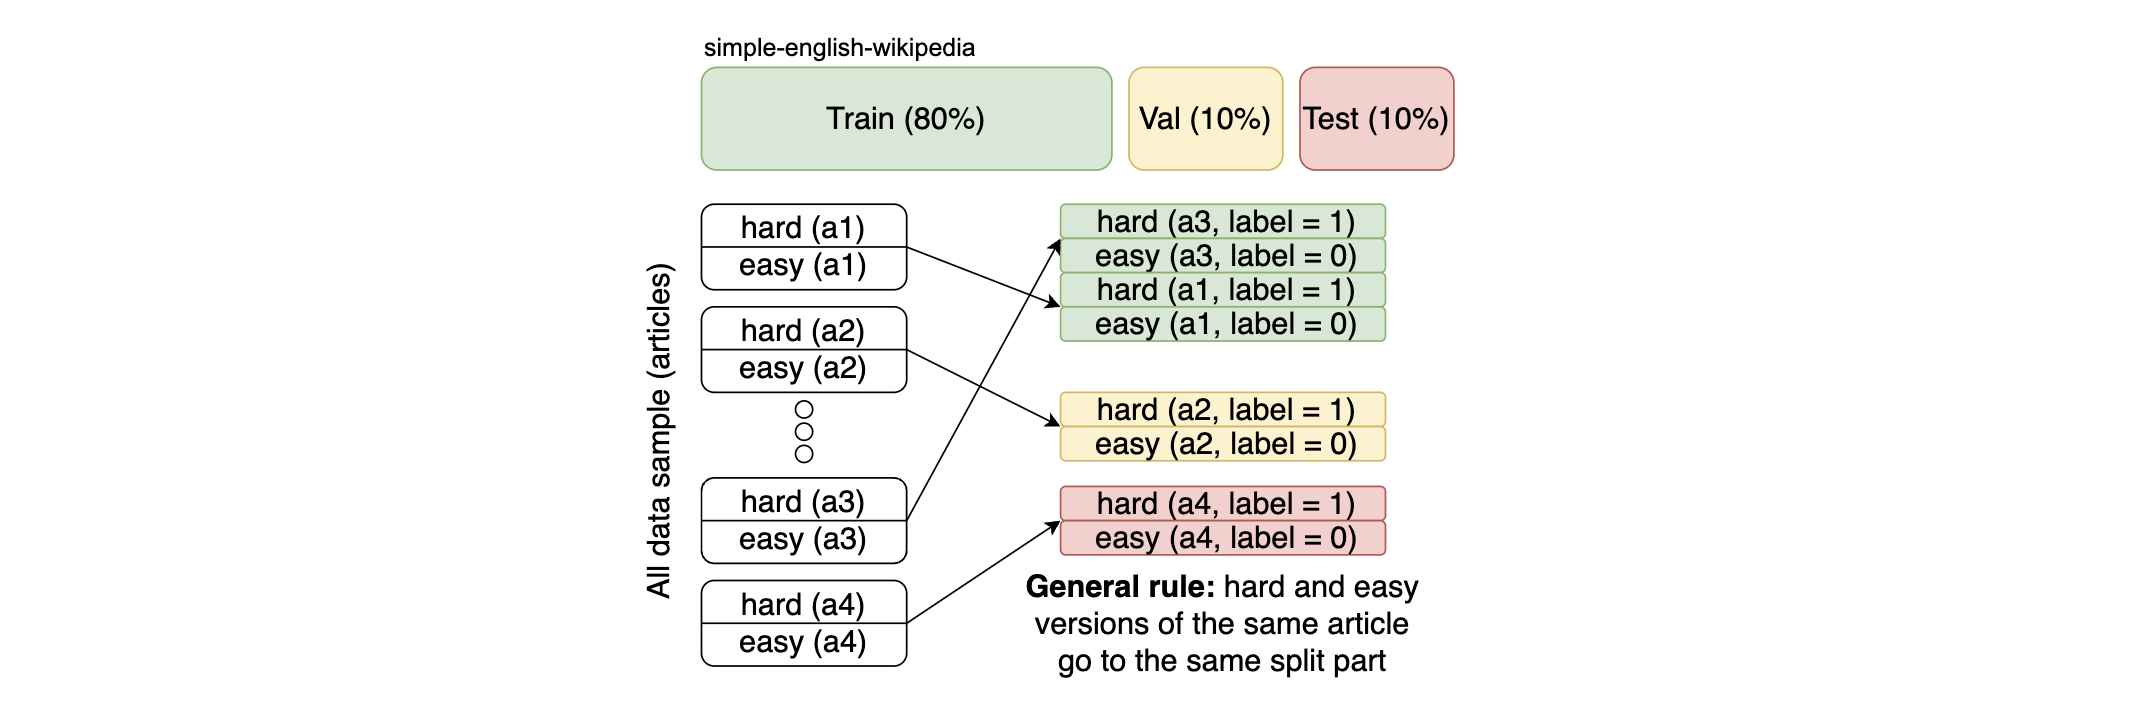

## Preparing data for full testing experiment (multilingual) (huggingface):

In [2]:
def build_df_from_list(data_list, shuffle=False):
    """
    Build sentence based dataframe from list of articles
    """
    en_data = [i['hard'] for i in data_list]
    simple_data = [i['easy'] for i in data_list]
    texts = []
    titles = []
    labels = []

    for article in en_data:
        sentences_to_add = article["text"]
        texts += sentences_to_add
        titles += [article["title"]] * len(sentences_to_add)
        labels += [1] * len(sentences_to_add)

    for article in simple_data:
        sentences_to_add = article["text"]
        texts += sentences_to_add
        titles += [article["title"]] * len(sentences_to_add)
        labels += [0] * len(sentences_to_add)

    df = pd.DataFrame({
        "title": titles,
        "text": texts,
        "label": labels
    })
    if shuffle:
        df = df.sample(len(df)) #shuffle
    return df 

In [3]:
testing_datasets = [
 'readability/data/children-api_vikidia-it_text.bz2',
 'readability/data/children-api_vikidia-oc_text.bz2',
 'readability/data/children-api_vikidia-el_text.bz2',
 'readability/data/children-api_vikidia-de_text.bz2',
 'readability/data/children-api_vikidia-ru_text.bz2',
 'readability/data/children-api_vikidia-es_text.bz2',
 'readability/data/children-api_vikidia-en_text.bz2',
 'readability/data/children-api_vikidia-ca_text.bz2',
 'readability/data/children-api_vikidia-hy_text.bz2',
 'readability/data/children-api_vikidia-scn_text.bz2',
 'readability/data/children-api_vikidia-pt_text.bz2',
 'readability/data/children-api_vikidia-fr_text.bz2',
 'readability/data/children-api_vikidia-eu_text.bz2',
 'readability/data/children-api_klexikon-de_text.bz2',
 'readability/data/children-api_wikikids-nl_text.bz2',
 'readability/data/txikipedia_text.bz2',
 'data/simple-en-validation.bz2',
 'data/simple-en-test.bz2',
]

data = {}
for file in tqdm(testing_datasets):
    data_cc = []
    if (file != 'data/simple-en-test.bz2') and (file != 'data/simple-en-validation.bz2'):
        with bz2.open(file,"rt") as fin:
            for line in fin:
                dict_in = json.loads(line)
                data_cc.append(dict_in)
    else:
        with open(file, 'r') as fout:
            for line in fout:
                dict_in = json.loads(line)
                data_cc.append(dict_in)
    data[file] = data_cc

100%|██████████| 18/18 [00:05<00:00,  3.13it/s]


In [4]:
dfs = []
for sample_name, sample in tqdm(data.items()):
    sample_df = build_df_from_list(sample, shuffle=False)
    sample_df["data_name"] = sample_name
    dfs.append(sample_df)

100%|██████████| 18/18 [00:00<00:00, 29.07it/s]


In [5]:
full_test = pd.concat(dfs)
full_test.to_csv("data/bert_full_test.csv", index=False)

## Make validation on full dataset

In [1]:
import pandas as pd
full_test = pd.read_csv("data/bert_full_test.csv")

In [ ]:
import numpy as np
from tqdm import tqdm
from datasets import load_dataset, load_metric, Dataset, ClassLabel, set_caching_enabled
from sklearn.metrics import roc_auc_score
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline

models = [
    "models/04_bert_final/checkpoint-622245",
]

testing_datasets = [
 'readability/data/children-api_vikidia-it_text.bz2',
 'readability/data/children-api_vikidia-oc_text.bz2',
 'readability/data/children-api_vikidia-el_text.bz2',
 'readability/data/children-api_vikidia-de_text.bz2',
 'readability/data/children-api_vikidia-ru_text.bz2',
 'readability/data/children-api_vikidia-es_text.bz2',
 'readability/data/children-api_vikidia-en_text.bz2',
 'readability/data/children-api_vikidia-ca_text.bz2',
 'readability/data/children-api_vikidia-hy_text.bz2',
 'readability/data/children-api_vikidia-scn_text.bz2',
 'readability/data/children-api_vikidia-pt_text.bz2',
 'readability/data/children-api_vikidia-fr_text.bz2',
 'readability/data/children-api_vikidia-eu_text.bz2',
 'readability/data/children-api_klexikon-de_text.bz2',
 'readability/data/children-api_wikikids-nl_text.bz2',
 'readability/data/txikipedia_text.bz2',
 'data/simple-en-test.bz2',
 'data/simple-en-validation.bz2',
]
testing_datasets_names = [
 'vikidia-it',
 'vikidia-oc',
 'vikidia-el',
 'vikidia-de',
 'vikidia-ru',
 'vikidia-es',
 'vikidia-en',
 'vikidia-ca',
 'vikidia-hy',
 'vikidia-scn',
 'vikidia-pt',
 'vikidia-fr',
 'vikidia-eu',
 'klexikon-de',
 'wikikids-nl',
 'txikipedia',
 'simple-en-test',
 'simple-en-validation',
]
names_dict = {k: v for k, v in zip(testing_datasets, testing_datasets_names)}


def preds_processing(preds):
    res = []
    for i in preds:
        res.append(i[1]['score'])
    return res

metrics_all_sentence = {}
auc_all_sentence = {}
results_files = {}
full_results_files = {}

for checkpoint in models:
    device = 0
    batch_size = 32 * 4
    
    tokenizer = AutoTokenizer.from_pretrained(checkpoint, truncation=True, max_length=512, device=device)
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint).to(device)
    clf = pipeline(task="text-classification", model=model, tokenizer=tokenizer, device=device, batch_size=batch_size)
    
    metrics = {}
    aucs = {}
    for file in tqdm(testing_datasets):
        tmp = full_test[full_test.data_name == file]
        # tmp = tmp.sample(np.min([100, len(tmp)]))
        
        tokenizer_kwargs = {'truncation': True, 'max_length': 512}
        preds = clf(tmp.text.to_list(), return_all_scores=True, **tokenizer_kwargs, batch_size=batch_size)

        # calculating score 
        tmp["score"] = preds_processing(preds)
        full_results_files[file] = tmp
        
        tmp_agg = tmp.groupby(["title", "label", "data_name"])["score"].agg(["mean", "count"]).reset_index()
        tmp_agg.columns = ["title", "label", "data_name", "mean", "sentence_count"]
        
        results_files[file] = tmp_agg
        
        tmp_agg["pred"] = tmp_agg["mean"] > 0.5
        metrics[file] = (tmp_agg.pred == tmp_agg.label).mean()
        # calculate auc
        aucs[file] = roc_auc_score(tmp_agg.label, tmp_agg["mean"])
    
    metrics_all_sentence[checkpoint] = metrics
    auc_all_sentence[checkpoint] = aucs

In [ ]:
import pickle
a = {'results_files': results_files, "full_results_files": full_results_files}
with open('data/prediction_dump.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('data/prediction_dump.pickle', 'rb') as handle:
#     b = pickle.load(handle)
# print(a == b)

## General metrics table:

In [52]:
metrics_df = pd.DataFrame(metrics_all_sentence)
metrics_df["AUC"] = pd.DataFrame(auc_all_sentence)
metrics_df.index = [names_dict[a] for a in metrics_df.index]
metrics_df.columns = ["Accuracy", "AUC"]
metrics_df

Accuracy       AUC
simple-en-test        0.891352  0.955451
simple-en-validation  0.893358  0.955407
klexikon-de           0.757636  0.948942
vikidia-ca            0.860656  0.914270
vikidia-de            0.690476  0.872446
vikidia-el            0.524390  0.761154
vikidia-en            0.921013  0.982656
vikidia-es            0.702041  0.822553
vikidia-eu            0.579792  0.611134
vikidia-fr            0.731558  0.826539
vikidia-hy            0.535455  0.695755
vikidia-it            0.763791  0.856777
vikidia-oc            0.571429  0.795918
vikidia-pt            0.811037  0.908483
vikidia-ru            0.701923  0.837555
vikidia-scn           0.636364  0.752066
wikikids-nl           0.715346  0.788743
txikipedia            0.425975  0.386073